# Cell annotation - Dendritic cells and monocytes in human blood

With this notebook, we show the example of annotation of cell data with cell type based on marker genes. We propose a fast annotation procedure using the Mann-Whitney U test for genes selection and the Hypergeometric test for cell-type annotation. 

This example demonstrates the annotation procedure on Dendritic cells and monocytes in human blood data [1]. 
For annotation, we use marker genes for cell types from PanglaoDB [2].

The whole annotation can be made by just calling one function, but since we want to show the intermediate results we will make the annotation in four steps: (1) Data normalization, (2) Selecting overexpressed genes with Mann-Whitney U test, (3) assigning the annotations with the hypergeometric test, and (4) filtering scores that do not meet p-value threshold.

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import numpy as np
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from openTSNE import TSNE
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import seaborn as sn

from IPython.display import HTML, display
import tabulate

from cellannotation.annotate_samples import *

### Data

Datasets are available [here](https://github.com/PrimozGodec/cell-annotation/releases/0.1.0) download them in data directory. If you are using unix based operating system it can be done with running:

In [9]:
!wget -q -nc -P data/ https://github.com/biolab/cell-annotation/releases/download/0.1.0/panglao_gene_markers.csv.gz
!wget -q -nc -P data/ https://github.com/biolab/cell-annotation/releases/download/0.1.0/DC_expMatrix_DCnMono.csv.gz

In [10]:
# currently we need only gene expression data so we remove last column - cell id
gene_expressions_df = pd.read_csv("data/DC_expMatrix_DCnMono.csv.gz", compression='gzip')
gene_expressions_df = gene_expressions_df.loc[:, gene_expressions_df.columns != "Cell ID"]

Data properties:

In [5]:
print("Number of cells in dataset: " + str(gene_expressions_df.shape[0]))
print("Number of genes in dataset: " + str(gene_expressions_df.shape[1]))

Number of cells in dataset: 1140
Number of genes in dataset: 26594


Since data are not normalized yet we will first nomralize them with log CPM normalization.

In [6]:
gene_expressions_normalized_df = AnnotateSamples.log_cpm(
    gene_expressions_df.loc[:, gene_expressions_df.columns != "Sample ID"])

### Most expressed genes per cell

With this step, we retrieve the z values for each gene-cell pair with Mann-Whitney U test. Z-value let us know whether the gene for this cell is more expressed compared to the same gene for all other cells. In hypergeometric test later we will just consider genes that have a z-value above 1.

In [7]:
%%time
z_df = AnnotateSamples.mann_whitney_test(gene_expressions_normalized_df)

CPU times: user 6.11 s, sys: 314 ms, total: 6.43 s
Wall time: 6.65 s


In [8]:
z_threshold = 1

#### Statistics: Expressed genes per cell

The histogram shows the number of genes with z-value above 1 per cell.

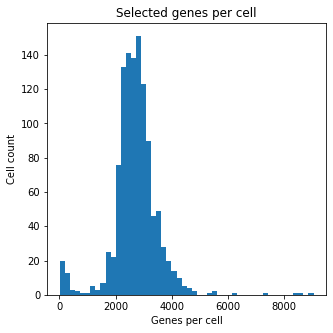

In [9]:
expressions_per_cell = (z_df > z_threshold).sum(axis=1)
plt.figure(figsize=(5,5))
plt.hist(expressions_per_cell, bins=50);
plt.title("Selected genes per cell");
plt.xlabel("Genes per cell")
plt.ylabel("Cell count");

### Loading marker genes

We use marker genes from PanglaoDB. We packed marker genes in `.csv` file for easier loading. Marker genes must have `Cell Type` and `Gene` column.

In [10]:
marker_genes_df = pd.read_csv("data/panglao_gene_markers.csv.gz", compression="gzip")
marker_genes_df = marker_genes_df.rename(columns={'Name': 'Gene'})
marker_genes_df = marker_genes_df[marker_genes_df["Organism"] == "Human"]

Check the number of marker genes that overlap with genes in the dataset:

In [11]:
len(set(gene_expressions_normalized_df.columns.values) & set(marker_genes_df.loc[:, 'Gene'].values))

4087

### Annotate

We use the hypergeometric test for annotation. It is made cell-vise. For each cell, it takes into account the number of genes by a cell type, number of genes selected for a cell by Mann-Whitney test, number of genes that overlap in the previous two sets and number of genes that the organism has. In our case, we take the number of genes discovered in the NCBI taxonomy database.

After the annotation scores that have a corrected p-value (FDR) below the threshold 0.05 are filtered out together with cell types that do not annotate any cell. The result is a scoring matrix where rows represent cells and columns represents cell-types.

In [12]:
%%time
scores_df, fdrs_df = AnnotateSamples.assign_annotations(
    z_df, marker_genes_df, gene_expressions_normalized_df, 61244)
# 61244 is number of genes in NCBI taxonomy database for human 
scores_df = AnnotateSamples.filter_annotations(
    scores_df, fdrs_df, return_nonzero_annotations=True, p_threshold=0.05)

CPU times: user 3.89 s, sys: 226 ms, total: 4.11 s
Wall time: 3.9 s


For each cell as a lable we select the cell type with the highest score value.

In [13]:
labels = np.array(scores_df.columns.values)  # get cell type names
labels_cells = scores_df.idxmax(axis=1)  # get the index of a maximal score per cell

#### Statistics: 10 most common labels

Here we show what are the most common cell-tyepes in this dataset.

In [14]:
counts = Counter(labels_cells).most_common()
counts_show = [[k, "{:.03f}".format(v / len(labels_cells))] for k, v in counts[:10]]

display(HTML("10 most common labels in the dataset and proportion of appearance"))
display(HTML(tabulate.tabulate(counts_show, tablefmt='html')))

Plasmacytoid dendritic cells,0.161
Langerhans cells,0.145
Myeloid-derived suppressor cells,0.113
Monocytes,0.104
Alveolar macrophages,0.05
Reticulocytes,0.04
Dendritic cells,0.03
Osteoclast precursor cells,0.027
Microfold cells,0.024
Thymocytes,0.02


### Comparison with dataset annotations

To check whether the annotation is relevant we plot a confusion matrix, where columns represent cell types which annotated by dataset authors and rows represent annotations by our technique.

In [15]:
ids = [str(i) for i in list(gene_expressions_df.loc[:, "Sample ID"])]
ids_unique = sorted(list(set(ids)))
lables_no_nan = labels_cells.dropna()
labels_unique = sorted(list(set(lables_no_nan)))

confusion_matrix = np.zeros((len(labels_unique), len(ids_unique)))
for l, idx in zip(lables_no_nan, ids):
    confusion_matrix[labels_unique.index(l), ids_unique.index(idx)] += 1

In [16]:
# subsample confusion matrix - take three most common cell types per column
n_maxs = 3
sel_ind = []
for i in range(confusion_matrix.shape[1]):
    ind = confusion_matrix[:, i].argsort()[-n_maxs:]
    sel_ind += [i for i in ind if i not in sel_ind]
conf_sub_smp = confusion_matrix[sel_ind]
labels_unique_sub = np.array(labels_unique)[sel_ind]

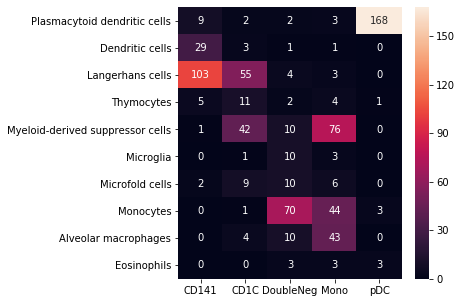

In [17]:
df_cm = pd.DataFrame(conf_sub_smp, index = labels_unique_sub, columns = ids_unique)
plt.figure(figsize=(5,5))
sn.heatmap(df_cm, annot=True, fmt='g');

### Annotations in tSNE plot

We reduce dimensionality of cell-data with the tSNE and then assign most common cell-type to groups in the tSNE plot. The dimensionality reduction is performed by openTSNE [3] the fast tSNE implementation. Groups are identified by DBSCAN.

In [22]:
pca = PCA(n_components=50)  # using PCA first speed up the tSNE
pca_data = pca.fit_transform(gene_expressions_normalized_df)
tsne = TSNE(n_components=2, n_jobs=4)
data_embedded = tsne.fit(pca_data)

/Users/primoz/miniconda3/envs/orange/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../miniconda3/envs/orange/lib/python3.7/site-packages/pynndescent/pynndescent_.py", line 38:
    @numba.njit(parallel=True, fastmath=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  self.func_ir.loc))
/Users/primoz/miniconda3/envs/orange/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../.

In [23]:
clustering = DBSCAN(eps=4, min_samples=2).fit(data_embedded)
clusters = clustering.labels_

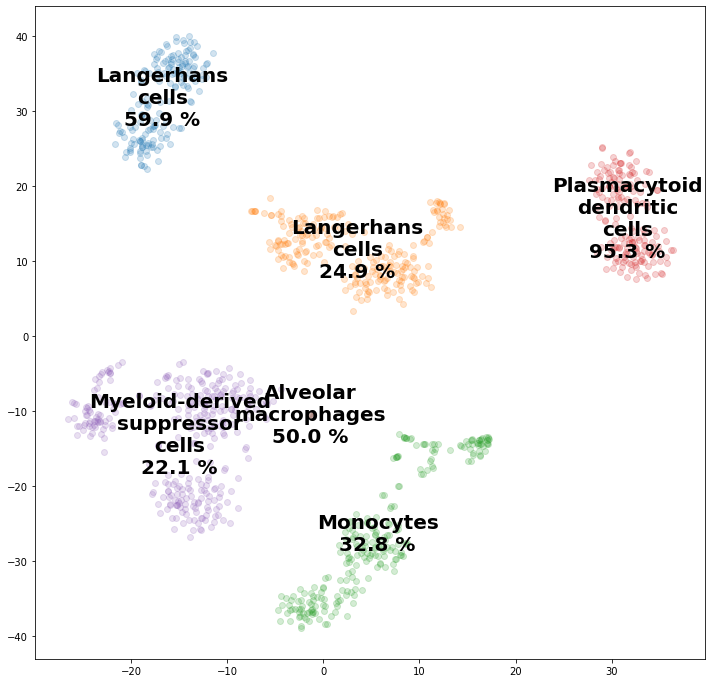

In [24]:
plt.figure(figsize=(12, 12))
for l in set(clusters) - {-1}:
    incl = clusters == l
    x = np.array(data_embedded)[incl, :]
    plt.scatter(x[:, 0], x[:, 1], label=l, alpha=0.2);
    
    center = x.mean(axis=0)    
    labels_cl = labels_cells.loc[incl].dropna()
    counts = Counter(labels_cl)
    
    max_el = "\n".join("{0}\n{1:.1f} %".format(
        "\n".join(k.split()), v / len(x) * 100) for k, v in counts.most_common(1))
    
    plt.annotate(max_el, 
                 center,
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=20, weight='bold');

# plot data from cluster -1 (unclustered data)
incl = clusters == -1
x = np.array(data_embedded)[incl, :]
plt.scatter(x[:, 0], x[:, 1], label=l, alpha=0.2, color="g");

### Cells-genes heatmap

For each cell, we select a few genes with the highest z-value and show their expressions. With this plot, we show that selected genes separate this cell type from other cell types. We show that the hypergeometric test selected the type that is described with shown genes.

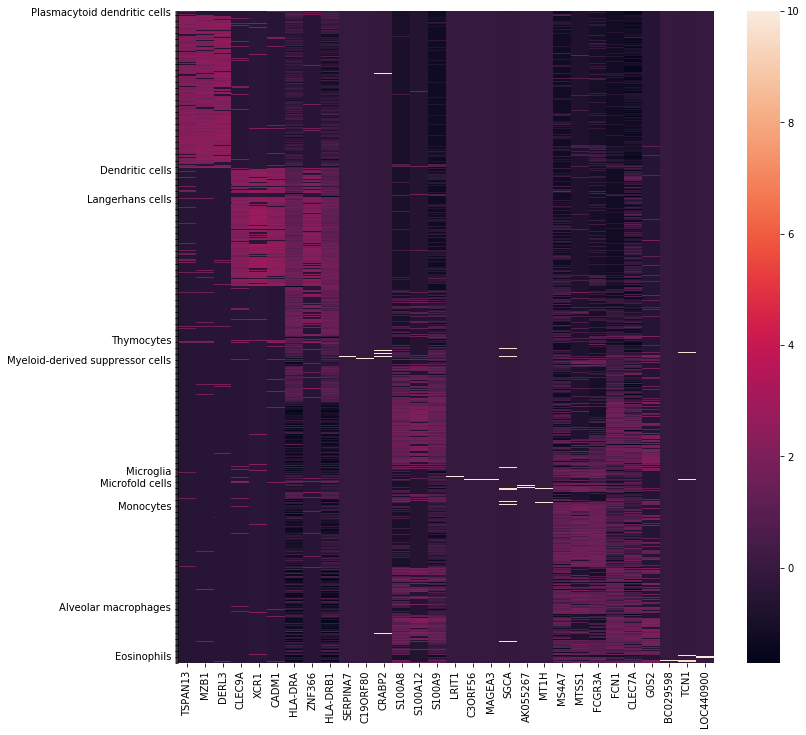

In [21]:
plt.figure(figsize=(12, 12))
n_genes_per_type = 3

# select genes with highest z-score for a cell in a group
selected_cells = np.array([]).astype(int)
selected_genes = np.array([]).astype(int)
y_tick_labels = []

labels_unique = sorted(list(set(labels_cells.dropna())))

for cell_type in labels_unique_sub:
    z_values_type = z_df[labels_cells == cell_type]
    genes_idx = z_values_type.mean(axis=0).argsort()[-n_genes_per_type:]
    selected_genes = np.concatenate([selected_genes, genes_idx])
    
    cells_idx1 = np.where(labels_cells == cell_type)[0]
    selected_cells = np.concatenate([selected_cells, cells_idx1])
    
    y_tick_labels += [cell_type] + [""] * (len(cells_idx1) - 1)


hm_array_df = z_df.iloc[selected_cells].iloc[:, selected_genes]
# hm_array_df = pd.DataFrame(hm_array, columns=genes_names[selected_genes])
hm_array_df = hm_array_df.clip(-100, 10)
sn.heatmap(hm_array_df, yticklabels=y_tick_labels);

### Bibliography

[1]    Villani, A. C., Satija, ... Jardine, L. (2017). Single-cell RNA-seq reveals new types of human blood dendritic cells, monocytes, and progenitors. Science, 356(6335).

[2]    Oscar Franzén, Li-Ming Gan, Johan L M Björkegren, PanglaoDB: a web server for exploration of mouse and human single-cell RNA sequencing data, Database, Volume 2019, 2019.

[3]    Poličar, P. G., Stražar, M., & Zupan, B. (2019). openTSNE: a modular Python library for t-SNE dimensionality reduction and embedding. BioRxiv, 731877. 